# Разработка демонстрационной версиюи поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберим либо одну из них, либо объединим их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import platform
import tensorflow as tf
import keras_nlp
import glob
import torch
import torch.nn as nn
import nltk
import re

from sentence_transformers import SentenceTransformer, util
from torchvision.transforms import transforms
from torchmetrics import MeanSquaredError
from torchvision import models
from pathlib import Path
from math import ceil
from tqdm import tqdm
from PIL import Image

from transformers import AutoModel, AutoTokenizer
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

from tqdm.autonotebook import tqdm
from tqdm.auto import tqdm
from tqdm import tqdm, notebook, trange

PATH = '/Users/urvanov_aleksandr/Yandex/Projects/image_research'
IMAGES_TRAIN = '/Users/urvanov_aleksandr/Yandex/Projects/image_research/train_images'
IMAGES_TEST = '/Users/urvanov_aleksandr/Yandex/Projects/image_research/test_images'
TEST_SAMPLES = 10
WORD_TO_BLOCK = ['child', 'boy', 'girl', 'baby', 'teen', 'teenager', 'kid', 'infant',
                 'youngster', 'kids', 'children', 'boys', 'girls', 'babies', 'teens',
                 'teenagers', 'toddler', 'young', 'toddlers', 'minor', 'youth', 'junior', 'infants']
SEED=12345


Using TensorFlow backend


In [2]:
# функция для чтения данных
def read_df(path=PATH) -> pd.DataFrame:

    df_train = pd.read_csv(Path(path, 'train_dataset.csv'))
    df_train.name = 'df_train'
    df_crowd = pd.read_csv(Path(path, 'CrowdAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'ratio_pos', 'pos', 'neg'])
    df_crowd.name = 'df_crowd'
    df_expert = pd.read_csv(Path(path, 'ExpertAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'first', 'second', 'third'])
    df_expert.name = 'df_expert'
    df_queries = pd.read_csv(Path(path, 'test_queries.csv'), index_col=[0], sep='|')
    df_queries.name = 'df_queries'
    df_images = pd.read_csv(Path(path, 'test_images.csv'), sep='|')
    df_images.name = 'df_images'

    return df_train, df_crowd, df_expert, df_queries, df_images

df_train, df_crowd, df_expert, df_queries, df_images = read_df()

In [3]:
# выводим данные для обучения
for dataframe in [df_train, df_crowd, df_expert]:
    print('____________________________________________________________________________________________')
    display(f'  {dataframe.name}  ')
    display(dataframe.info())
    display(dataframe.sample(5))



____________________________________________________________________________________________


'  df_train  '

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

image                     query_id  \
2194   307327914_f98f576adb.jpg  3584930205_a3f58a4b7c.jpg#2   
1837  2103568100_5d018c495b.jpg   197107117_4b438b1872.jpg#2   
4097  2602258549_7401a3cdae.jpg  2224450291_4c133fabe8.jpg#2   
1650  2189995738_352607a63b.jpg  2196846255_2c1635359a.jpg#2   
4845  3119875880_22f9129a1c.jpg  2120383553_5825333a3f.jpg#2   

                                             query_text  
2194                 a skateboarder ollies off a ramp .  
1837  A rock climber climbs in between two very larg...  
4097      A man taking a picture with a silver camera .  
1650           A wrinkled dog wading in shallow water .  
4845  A little girl in a green outfit wringing out a...

____________________________________________________________________________________________


'  df_crowd  '

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   ratio_pos  47830 non-null  float64
 3   pos        47830 non-null  int64  
 4   neg        47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

image                     query_id  ratio_pos  pos  \
1280   1282392036_5a0328eb86.jpg  2968182121_b3b491df85.jpg#2   0.000000    0   
42989   444057017_f1e0fcaef7.jpg  2300168895_a9b83e16fc.jpg#2   0.000000    0   
2344   1402640441_81978e32a9.jpg  2274992140_bb9e868bb8.jpg#2   0.000000    0   
42003   400851260_5911898657.jpg  2075321027_c8fcbaf581.jpg#2   0.000000    0   
28593  3239021459_a6b71bb400.jpg  3214237686_6566b8b52f.jpg#2   0.666667    2   

       neg  
1280     3  
42989    3  
2344     3  
42003    3  
28593    1

____________________________________________________________________________________________


'  df_expert  '

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

image                     query_id  first  second  \
3072  3119875880_22f9129a1c.jpg   506738508_327efdf9c3.jpg#2      1       1   
3277  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2      1       2   
4947  3701291852_373ea46bb6.jpg  3006093003_c211737232.jpg#2      1       1   
4200  3468694409_a51571d621.jpg  1461667284_041c8a2475.jpg#2      1       2   
2204  2797149878_bb8e27ecf9.jpg  2522297487_57edf117f7.jpg#2      1       1   

      third  
3072      1  
3277      2  
4947      1  
4200      3  
2204      2

In [4]:
# выводим данные для теста
for dataframe in [df_queries, df_images]:
    print('____________________________________________________________________________________________')
    display(f'  {dataframe.name}  ')
    display(dataframe.info())
    display(dataframe.sample(5))




____________________________________________________________________________________________


'  df_queries  '

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

query_id  \
385  3520936130_9e90872560.jpg#0   
480   957682378_46c3b07bcd.jpg#0   
363  3482859574_3908de3427.jpg#3   
471   862156271_3eacea90a8.jpg#1   
407  3653484549_f316590b0f.jpg#2   

                                            query_text  \
385  A man and a woman are sitting on a bench outsi...   
480  A brown dog and a black dog run into each othe...   
363  A group of three females and one male dressed ...   
471                    two girls walking in the street   
407  A little girl blows out the candles on her cake .   

                         image  
385  3520936130_9e90872560.jpg  
480   957682378_46c3b07bcd.jpg  
363  3482859574_3908de3427.jpg  
471   862156271_3eacea90a8.jpg  
407  3653484549_f316590b0f.jpg

____________________________________________________________________________________________


'  df_images  '

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None

image
31  2107838729_a527e434bd.jpg
87  2552438538_285a05b86c.jpg
85  3398788809_25c71ba018.jpg
30  3393035454_2d2370ffd4.jpg
7   3396275223_ee080df8b5.jpg

In [5]:
print('Количество уникальных изображений в обучающем наборе:', len(df_train['image'].unique()))
print('Количество уникальных изображений в тестовом наборе:', len(df_queries['image'].unique()))

Количество уникальных изображений в обучающем наборе: 1000
Количество уникальных изображений в тестовом наборе: 100


In [6]:
print('Количество уникальных запросов на тесте:', df_queries.drop_duplicates().shape[0])

Количество уникальных запросов на тесте: 500


In [7]:
print('Количество уникальных сочетаний изображение-текст оцененных экспертами:', df_expert.drop_duplicates().shape[0])
print('Количество уникальных сочетаний изображение-текст оцененных краудсорсингом:', df_crowd.drop_duplicates().shape[0])

Количество уникальных сочетаний изображение-текст оцененных экспертами: 5822
Количество уникальных сочетаний изображение-текст оцененных краудсорсингом: 47830


In [8]:
print('Уникальных текстовых описаний в обучающем наборе:', len(set(df_train['query_text'])))
print('Уникальных текстовых описаний в тестовом наборе:', len(set(df_queries['query_text'])))
print('Текстовые описания, которые есть в обоих наборах:', len(set(df_train['query_text'])
                                                                         & set(df_queries['query_text'])))

Уникальных текстовых описаний в обучающем наборе: 977
Уникальных текстовых описаний в тестовом наборе: 500
Текстовые описания, которые есть в обоих наборах: 0


In [9]:
print('Уникальных изображений в обучающем наборе:', len(set(df_train['image'])))
print('Уникальных изображений в тестовом наборе:', len(set(df_queries['image'])))
print('Уникальных изображений, которые есть в обоих наборах:', len(set(df_train['image']) & set(df_queries['image'])))

Уникальных изображений в обучающем наборе: 1000
Уникальных изображений в тестовом наборе: 100
Уникальных изображений, которые есть в обоих наборах: 0


In [10]:
# функция для просмотра изображений
def image_show(images, titles=None, nums=None):

    fig = plt.figure(figsize=(10, 10))

    for i in range(4):
        fig.add_subplot(2, 2, i + 1)
        img = Image.open(images[i])
        if titles != None:
            if nums != None:
                if nums[i] == None:
                    plt.title(f'\n{titles[i]}', fontsize = 10)
                else:
                    plt.title(f'\n{str(nums[i])}\n{titles[i]}', fontsize = 10)
            else:
                plt.title(f'\n{titles[i]}', fontsize = 10)
        plt.axis('off')
        plt.imshow(img)

    plt.show()

Тестовый набор


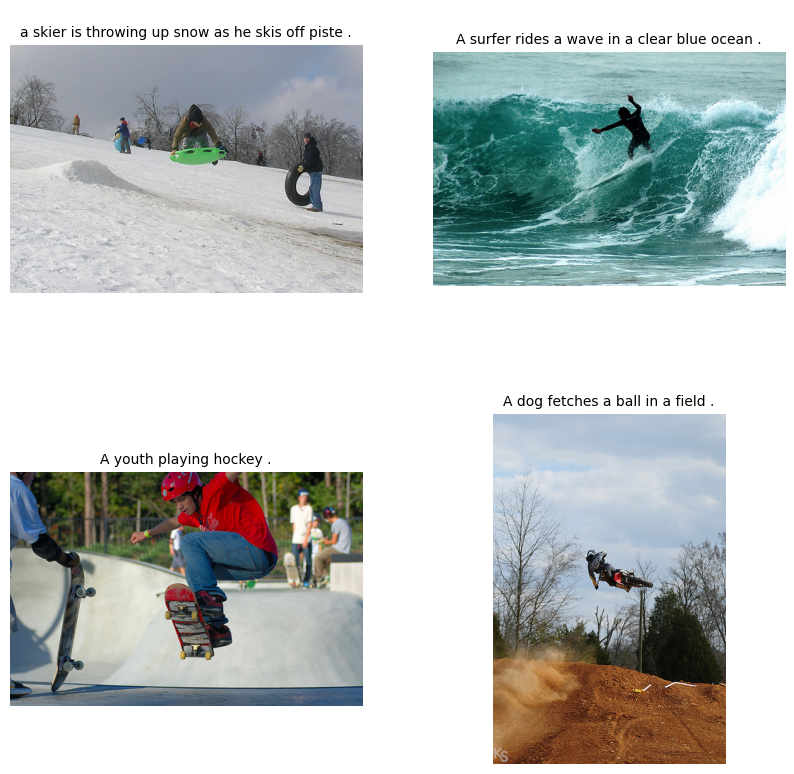

In [11]:
# выведем примеры изображения в обучающем наборе
images_train = df_train.sample(4)
images_train.reset_index(inplace=True)
print('Тестовый набор')

images = []
texts = []

for i in range(images_train.shape[0]):
    images.append(f'{IMAGES_TRAIN}/{images_train.iloc[i]["image"]}')
    texts.append(images_train.iloc[i]['query_text'])

image_show(images, texts)

Тестовый набор


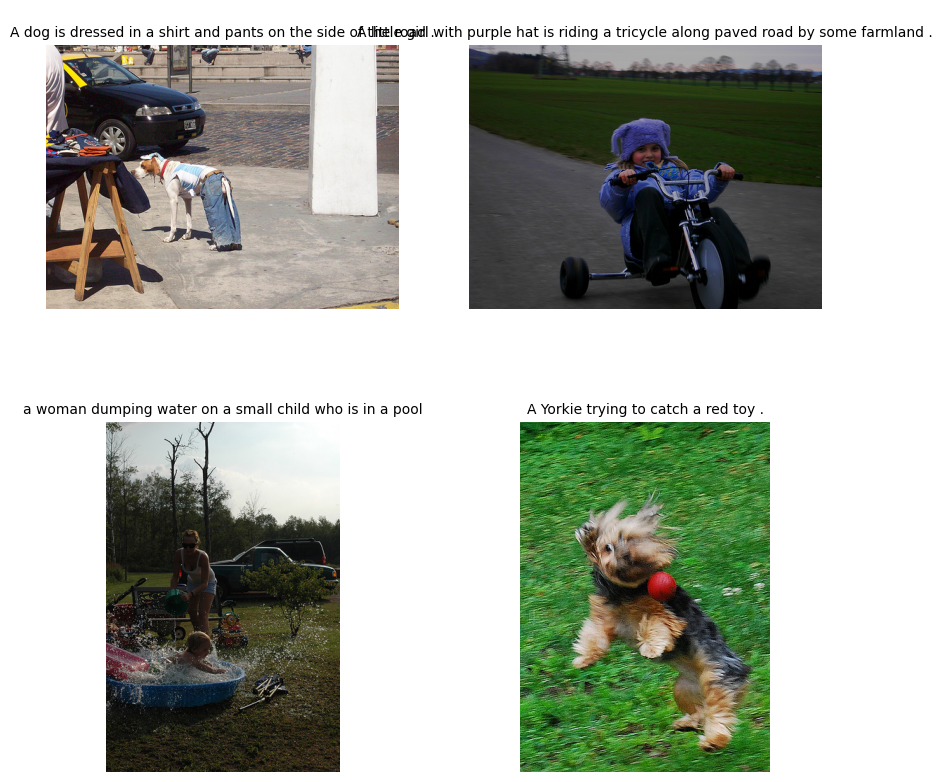

In [12]:
# выведем примеры изображения в тестовом наборе
images_test = df_queries.sample(4)
images_test.reset_index(inplace=True)
print('Тестовый набор')

images = []
texts = []

for i in range(images_test.shape[0]):
    images.append(f'{IMAGES_TEST}/{images_test.iloc[i]["image"]}')
    texts.append(images_test.iloc[i]['query_text'])

image_show(images, texts)

Мы загрузили и ознакомились с данными.

Для обучающей выборки использованы экспертные оценки соответствия - 5822 шт,  оценки выполненные с помощью краудсорсинга  - 47830 шт, они частично совпадают. Пересечений между наборами нет. Перейдём к аггрегации оценок.

In [13]:
# агрегируем экспертную оценку усреднением ответов и сведением к диапазону [0,1]
def expert_aggregate(row) -> object:

    if row['first'] != row['second'] != row['third']: #если оценки разные усредняем
        row['expert_score'] = (row['first'] + row['second'] + row['third'] - 3) / 3 / 3

    else: #если есть одинаковые оценки - аггрегируем голосованием
        row['expert_score'] = (max(set([row['first'], row['second'], row['third']]),
                                   key = [row['first'], row['second'], row['third']].count) - 1) / 3

    return row

df_expert = df_expert.apply(expert_aggregate, axis=1)
display(df_expert.head(3))


image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   

   third  expert_score  
0      1           0.0  
1      2           0.0  
2      2           0.0

In [14]:
# удаляем ненужные столбцы
df_expert.drop(columns=['first', 'second', 'third'], axis= 1 , inplace= True)

In [15]:
df_scores = pd.merge(df_expert, df_crowd, how='outer', on=['image', 'query_id'])
display(df_scores.sample(5))


image                     query_id  expert_score  \
35052  3320032226_63390d74a6.jpg  2646116932_232573f030.jpg#2           NaN   
3830   3348385580_10b53391f9.jpg  3348385580_10b53391f9.jpg#2           1.0   
51169    96420612_feb18fc6c6.jpg  3085667767_66041b202e.jpg#2           NaN   
45321  3741462565_cc35966b7a.jpg  2689001252_e0016c89f0.jpg#2           NaN   
46869   448252603_7d928c900e.jpg  2924259848_effb4dcb82.jpg#2           NaN   

       ratio_pos  pos  neg  
35052        0.0  0.0  3.0  
3830         1.0  3.0  0.0  
51169        0.2  1.0  4.0  
45321        0.0  0.0  3.0  
46869        0.0  0.0  3.0

In [16]:
# агрегируем оценки людей и экспертов

def score_aggregate(row) -> object:

    if np.isnan(row['expert_score']):
        row['score'] = row['ratio_pos']
    elif np.isnan(row['ratio_pos']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.6 + row['ratio_pos'] * 0.4

    return row

df_scores = df_scores.apply(score_aggregate, axis=1)
display(df_scores.head(3))

image                     query_id  expert_score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2           0.0   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2           0.0   

   ratio_pos  pos  neg  score  
0        0.0  0.0  3.0    0.0  
1        0.0  0.0  3.0    0.0  
2        NaN  NaN  NaN    0.0

In [17]:
# удаляем ненужные столбцы
df_scores.drop(columns=['expert_score', 'ratio_pos', 'pos', 'neg'], axis= 1 , inplace= True)

In [18]:
# проверяем данные на наличие дубликатов
df_scores.duplicated().sum()

0

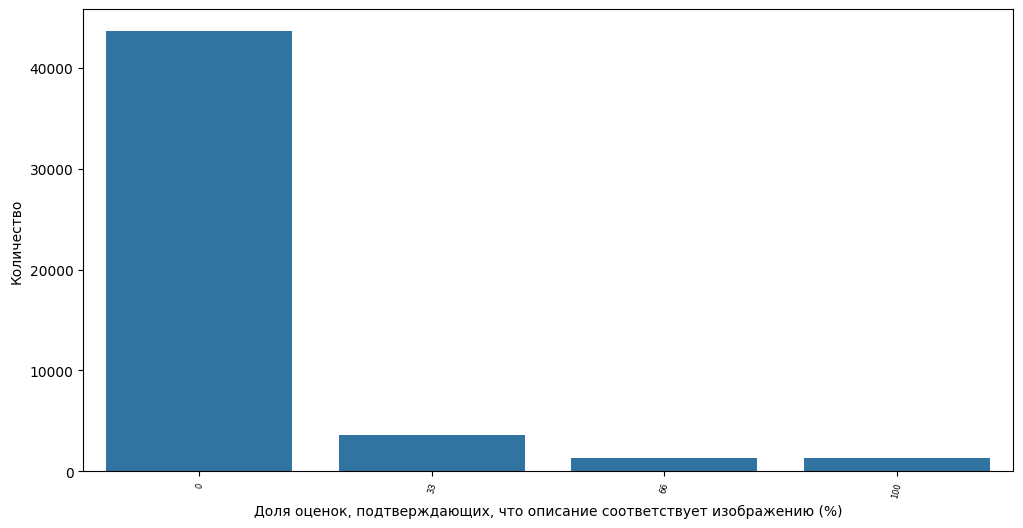

In [19]:
# выведем соотношение количества ответов от общего количества оценок
analicit_score = df_scores.copy()
analicit_score['score'] *= 100
analicit_score['score'] = analicit_score['score'].astype('int')
crowd_array=[]
score_nums = np.array([0, 33, 66, 100])
for i in score_nums:
    crowd_array.append((analicit_score['score'] == i).sum())

plt.figure(figsize=(12, 6))
sns.barplot(x = score_nums, y = crowd_array)
plt.xticks(rotation=75, size=6)
plt.xlabel('Доля оценок, подтверждающих, что описание соответствует изображению (%)')
plt.ylabel('Количество')
plt.show()

In [20]:
# соединим оценки с обучающим датасетом
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])


In [21]:
# создаем справочник из уникальных пар "query_id", "query_text"
query_id_text = df_train[['query_id', 'query_text']].drop_duplicates()

In [22]:
# соединяем с основным датафреймом
df_train = df_train.drop(columns=['query_text']).merge(query_id_text, how="left", on=['query_id'])

In [23]:
# удаляем записи с пропусками
df_train.dropna(axis = 'index', inplace = True)
df_train.isnull().sum()

image         0
query_id      0
score         0
query_text    0
dtype: int64

In [26]:
# выводим получившийся датафрейм
df_train.info()
display(df_train)

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 101535
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   score       50214 non-null  float64
 3   query_text  50214 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


image                     query_id     score  \
0       1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  0.000000   
2       1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2  0.000000   
4       2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2  0.200000   
6       2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2  1.000000   
8       2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2  0.000000   
...                           ...                          ...       ...   
101527   997722733_0cb5439472.jpg   543007912_23fc735b99.jpg#2  0.000000   
101529   997722733_0cb5439472.jpg   544576742_283b65fa0d.jpg#2  0.333333   
101531   997722733_0cb5439472.jpg   872622575_ba1d3632cc.jpg#2  1.000000   
101533   997722733_0cb5439472.jpg   888425986_e4b6c12324.jpg#2  0.000000   
101535   997722733_0cb5439472.jpg   997722733_0cb5439472.jpg#2  0.666667   

                                               query_text  
0       A young child is wearing blue goggles and sitt...  
2       A young child is wearing blue goggles and sitt...  
4       A young child is wearing blue goggles and sitt...  
6       A young child is wearing blue goggles and sitt...  
8       A young child is wearing blue goggles and sitt...  
...                                                   ...  
101527                     Two girls with orange shirts .  
101529                   A woman in jeans rock climbing .  
101531         A man is climbing the side of a mountain .  
101533                      A person flipping upside down  
101535  A person in a red shirt climbing up a rock fac...  

[50214 rows x 4 columns]

## Вывод

Аггрегировали экспертные оценки с оценками, полученными с помощью краудсорсинга и свели к диапазону [0,1] на выходе. Проверили на дубликаты. Заполнили пропуски. Данные готовы к следующему этапу.

## 2. Проверка данных

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.



In [27]:
lemmatize = nltk.WordNetLemmatizer()

def lemmas(text) -> list:

    text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatize.lemmatize(word) for word in text] # лемматизируем слова

    return text

def prohibited(row) -> object:

    text = lemmas(row['query_text'])
    if [i for i in text if i in WORD_TO_BLOCK]:
        row['word_block'] = 1
    else:
        row['word_block'] = 0

    return row


In [28]:
%time df_train = df_train.apply(prohibited, axis=1)

CPU times: user 13.1 s, sys: 79.9 ms, total: 13.1 s
Wall time: 13 s


In [29]:
display(df_train.sample(5))

image                     query_id  score  \
24374  2167644298_100ca79f54.jpg  2621415349_ef1a7e73be.jpg#2    0.0   
41597  2649406158_ded6be38de.jpg  1394368714_3bc7c19969.jpg#2    0.0   
5442   2813992915_f732cf8539.jpg   444057017_f1e0fcaef7.jpg#2    0.0   
34907   247704641_d883902277.jpg   505929313_7668f021ab.jpg#2    0.0   
98459   566397227_a469e9e415.jpg   416106657_cab2a107a5.jpg#2    0.0   

                                              query_text  word_block  
24374  A man wearing sunglasses and a red cap putting...           0  
41597  A man with a pug dog bends over to pick someth...           0  
5442    A little girl on a piece of playground equipment           1  
34907  A black dog standing in shallow water with a p...           0  
98459                    A white dog runs in the grass ,           0

In [30]:
# список 'query_id' c плохими комментариями
bad_comments = (df_train[df_train['word_block'] == 1]['query_id'])

In [31]:
# список запрещенных фото, которые нужно удалить
bad_images = bad_comments.map(lambda x: str(x)[:-2])

In [32]:
# удаляем из датафрейма все запрещенные фото
df_train = df_train[df_train['image'].isin(bad_images) == False]
df_train.reset_index(inplace=True)

In [33]:
display(df_train)

index                      image                     query_id  \
0           0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1           2  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2           8  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
3          12  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
4          14  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
...       ...                        ...                          ...   
35050  101527   997722733_0cb5439472.jpg   543007912_23fc735b99.jpg#2   
35051  101529   997722733_0cb5439472.jpg   544576742_283b65fa0d.jpg#2   
35052  101531   997722733_0cb5439472.jpg   872622575_ba1d3632cc.jpg#2   
35053  101533   997722733_0cb5439472.jpg   888425986_e4b6c12324.jpg#2   
35054  101535   997722733_0cb5439472.jpg   997722733_0cb5439472.jpg#2   

          score                                         query_text  word_block  
0      0.000000  A young child is wearing blue goggles and sitt...           1  
1      0.000000  A young child is wearing blue goggles and sitt...           1  
2      0.000000  A young child is wearing blue goggles and sitt...           1  
3      0.000000  A young child is wearing blue goggles and sitt...           1  
4      0.000000  A young child is wearing blue goggles and sitt...           1  
...         ...                                                ...         ...  
35050  0.000000                     Two girls with orange shirts .           1  
35051  0.333333                   A woman in jeans rock climbing .           0  
35052  1.000000         A man is climbing the side of a mountain .           0  
35053  0.000000                      A person flipping upside down           0  
35054  0.666667  A person in a red shirt climbing up a rock fac...           0  

[35055 rows x 6 columns]

## Вывод

Отчистили текст от неалфавитных символов, привели к нижнему регистру. Также провели токенизацию и лемматизацию. Удалили из нашего датафрейма все запрещенные фото.

## 3. Векторизация изображений

Перейдём к векторизации изображений.


In [41]:
def image_to_tensor(image_names, data):

    # загрузим модель inception_v3 с предобученными параметрами
    model_extractor = models.inception_v3(pretrained=True)

    # заморозим веса
    for param in model_extractor.parameters():
        param.requires_grad_(False)

    model_extractor.fc = nn.Identity()
    model_extractor = model_extractor.to()

    # переведем модель в режим предсказания
    model_extractor.eval();

    output_vectors = []
    images_names_list = image_names.values
    preprocess = transforms.Compose([
      transforms.Resize(299),
      transforms.CenterCrop(299),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),
    ])

    if data == 'train':
        folder = 'train_images'
    elif data == 'test':
        folder = 'test_images'

    for img_name in images_names_list:
        img = Image.open(f"{PATH}/{folder}/{img_name}").convert('RGB')
        image_tensor = preprocess(img).unsqueeze(0)
        output_tensor = model_extractor(image_tensor.to()).flatten()
        output_vectors.append(output_tensor.cpu().numpy())
        torch.cuda.empty_cache()
    return np.array(output_vectors)


In [42]:
image_embeds = image_to_tensor(image_names=df_train['image'], data='train')

/Users/urvanov_aleksandr/venv-metal/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/urvanov_aleksandr/venv-metal/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
# выведем форму, получившихся эмбедингов
image_embeds.shape

(35055, 2048)

## Вывод

Провели векторизацию изображений.

## 4. Векторизация текстов



In [44]:
# обучать будем на специальной модели
model_text = SentenceTransformer('distilbert-base-uncased')


No sentence-transformers model found with name /Users/urvanov_aleksandr/.cache/torch/sentence_transformers/distilbert-base-uncased. Creating a new one with MEAN pooling.


In [45]:
# преобразуем текст для модели
text = list(df_train['query_text'])

In [46]:
# получаем эмбеддинги
%time
text_embeds = model_text.encode(text)

CPU times: user 2 µs, sys: 8 µs, total: 10 µs
Wall time: 9.06 µs


In [47]:
# выведем форму, получившихся эмбедингов
text_embeds.shape

(35055, 768)

## Вывод

Провели векторизацию текста с помощью библиотеки SentenceTransformers

## 5. Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.

In [48]:
# признаки
X = np.concatenate((image_embeds, text_embeds), axis=1)
X.shape

(35055, 2816)

In [49]:
# целевой признак
y = np.array(df_train['score'])
y.shape

(35055,)

## Вывод


По итогам объединения векторов изображений и векторов текстов вектор признаков и целевой переменной.

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.


In [50]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=SEED)
train_indices, valid_indices = next(gss.split(X=X, y=y, groups=df_train['image']))

In [51]:
X_train, X_valid = X[train_indices], X[valid_indices]
y_train, y_valid = y[train_indices], y[valid_indices]

In [52]:
# масштабируем данные
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

Будем использовать 2 модели: Ridge, NeuralNetwork. В качестве метрики остановимся на RMSE, cреднеквадратичная ошибка хорошо подходит для задач регрессии, будем оценивать, насколько сильно отличается вероятность верного описания картинки от той вероятности, которую мы ранее вычислили и поместили в значение целевой переменной.

## LinearRegression

In [53]:
# функция для RMSE
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

Будем использовать не классическую линейную регрессию, а Ridge ( линейная регрессия с оптимизацией MSE и l2
-регуляризацией)

In [54]:
%%time
model = Ridge()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)


print("RMSE на обучающей выборке = %.4f" % rmse(y_train, y_train_pred))
print("RMSE на валидационной выборке = %.4f" % rmse(y_valid, y_valid_pred))

RMSE на обучающей выборке = 0.2019
RMSE на валидационной выборке = 0.2185
CPU times: user 9.95 s, sys: 283 ms, total: 10.2 s
Wall time: 1.48 s


/Users/urvanov_aleksandr/venv-metal/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.6407e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Посчитаем оптимальное значение функции потерь при константном предсказании.

In [55]:
best_constant = y_train.mean()
print("RMSE на обучающей выборке = %.4f" % rmse(y_train, best_constant))
print("RMSE на валидационной выборке = %.4f" % rmse(y_valid, best_constant))

RMSE на обучающей выборке = 0.2207
RMSE на валидационной выборке = 0.2176


_______________________________________________________

## NeuralNetwork

In [56]:
X_train.shape

(24454, 2816)

In [57]:
n_in_neurons, n_out_neurons = X_train.shape[1], 1

In [58]:
rmse = MeanSquaredError(squared = False)

In [59]:
class Net(nn.Module):

    def __init__(self, input_dim=n_in_neurons, num_layers=0, hidden_dim=64, output_dim=n_out_neurons, p=0.0, div=0):
        super().__init__()
        self.layers = torch.nn.Sequential()

        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i),
                                   torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module(f'batchnorm{i}',
                                   torch.nn.BatchNorm1d(hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
            if div!=0 and div!=1:
                hidden_dim = hidden_dim // 2

        self.layers.add_module('classifier', torch.nn.Linear(prev_size, output_dim))


    def forward(self, x):
        return self.layers(x)

    def fit(self,
            train,
            y_train,
            batch_size=16,
            num_epochs=10,
            lr=0.000001,
            val=None,
            y_val=None,
            plot_scores=True):

        self.train_scores = []
        self.best_train_score = 0
        self.best_train_epoch = 0

        self.val_scores = []
        self.best_val_score = 0
        self.best_val_epoch = 0

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss = nn.MSELoss()


        num_batches = ceil(train.shape[0] / batch_size)
        epoches = []

        for epoch in notebook.tqdm(range(num_epochs)):
            if epoch % 1 == 0:
                print(f'Epoch: {epoch}/{num_epochs}')
                try:
                    print(f'Loss = {loss_value}')
                    print()
                except UnboundLocalError:
                    pass

            self.train()
            order = np.random.permutation(train.shape[0])
            epoches.append(epoch)

            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size
                batch_indexes = order[start_index:start_index + batch_size]
                X_batch = train[batch_indexes]
                y_batch = y_train[batch_indexes]
                optimizer.zero_grad()
                preds = self.forward(X_batch).flatten()
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()

            self.eval()

            preds = self.forward(train).flatten()
            score = float(rmse(preds, y_train))
            self.train_scores.append(score)

            if val is not None and y_val is not None:
                preds = self.forward(val).flatten()
                score = float(loss(preds, y_val))
                self.val_scores.append(score)

        self.best_train_score = min(self.train_scores)
        self.best_train_epoch = np.argmin(self.train_scores)

        try:
            self.best_val_score = min(self.val_scores)
            self.best_val_epoch = np.argmin(self.val_scores)
        except:
            pass

        if plot_scores:
            sns.lineplot(x=epoches, y=self.train_scores, label='train')

            print(f'Лучшая эпоха на обучающей выборке:  {self.best_train_epoch}')
            print(f'Лучший RMSE на обучающей выборке: {self.best_train_score:0.2f}')

            if val is not None and y_val is not None:
                sns.lineplot(x=epoches, y=self.val_scores, label='val')

                print(f'Лучшая эпоха на валидационной выборке: {self.best_val_epoch}')
                print(f'Лучший RMSE на валидационной выборке: {self.best_val_score:0.2f}')
            plt.title('График метрики по эпохам')
            plt.xlabel('Номер эпохи')
            plt.ylabel('RMSE')
            plt.legend()
            plt.grid()
            plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0/10
Epoch: 1/10
Loss = 0.38875702023506165

Epoch: 2/10
Loss = 0.7621620297431946

Epoch: 3/10
Loss = 0.14069820940494537

Epoch: 4/10
Loss = 0.735948383808136

Epoch: 5/10
Loss = 0.20655636489391327

Epoch: 6/10
Loss = 0.2110767364501953

Epoch: 7/10
Loss = 0.15725980699062347

Epoch: 8/10
Loss = 0.11353618651628494

Epoch: 9/10
Loss = 0.08344953507184982

Лучшая эпоха на обучающей выборке:  9
Лучший RMSE на обучающей выборке: 0.34
Лучшая эпоха на валидационной выборке: 9
Лучший RMSE на валидационной выборке: 0.11


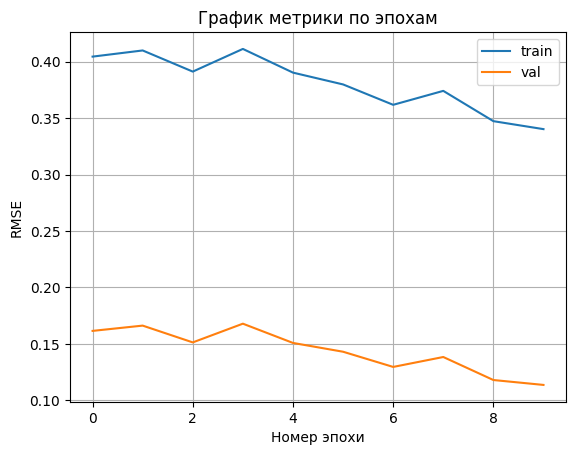

In [60]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_valid_tensor = torch.FloatTensor(X_valid)
y_valid_tensor = torch.FloatTensor(y_valid)

model_nn = Net(X_train_tensor.shape[1], 256, 64, 1, 0.1)
model_nn.fit(X_train_tensor,
          y_train_tensor,
          val=X_valid_tensor,
          y_val=y_valid_tensor,
          num_epochs=10,
          batch_size=32)

torch.save(model_nn, 'net.pkl')

Нейронная сеть показала себя лучше, RMSE на валидационной выборке 0.07.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

In [62]:
 # получаем эмбеддинги тестовых фото
image_embeds_test = image_to_tensor(image_names=df_queries['image'], data='test')

/Users/urvanov_aleksandr/venv-metal/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/urvanov_aleksandr/venv-metal/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
# преобразуем текст для модели
text = list(df_queries['query_text'])

In [64]:
# получаем эмбеддинги описаний тестовых фото
%time
text_embed = model_text.encode(text)

CPU times: user 2 µs, sys: 6 µs, total: 8 µs
Wall time: 8.11 µs


In [65]:
# функция для теста работы модели и визульного контроля качества
def get_picture(text):

    bin_array = [i for i in lemmas(text) if i in WORD_TO_BLOCK]
    if bin_array:
        print('-'*100)
        print()
        print(text)
        print()
        print('#'*77)
        s = 'This image is unavailable in your country in compliance with local laws'.upper()
        print(f'## {s} ##')
        print('#'*77)
        print()
    else:
        feature = np.concatenate((image_embeds_test, np.resize(text_embed, (image_embeds_test.shape[0],768))), axis=1)
        feature = torch.FloatTensor(feature)
        net2 = torch.load('net.pkl')
        pred = net2(feature)
        predictions = pred.detach().cpu().numpy()
        predictions = abs(predictions)

        data = pd.concat((df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='predictions')), axis=1)
        data = data.dropna()
        top = list(data.sort_values(by='predictions', ascending=False)['image'].sample(5))
        top_score = list(data.sort_values(by='predictions', ascending=False)['predictions'].head(5))


        print()
        print(text)
        print()

        fig = plt.figure(figsize=(15,6))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0

        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(Path(PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if text in list(df_queries['query_text']):
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            print()

        plt.show()

        print('-'*100)
    return None

----------------------------------------------------------------------------------------------------

Children in swimming suits playing in water .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

A boy is flying a kite and smiling at the camera .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

a boy flings sand at a girl .

#############################################################################
## THIS IMAGE IS

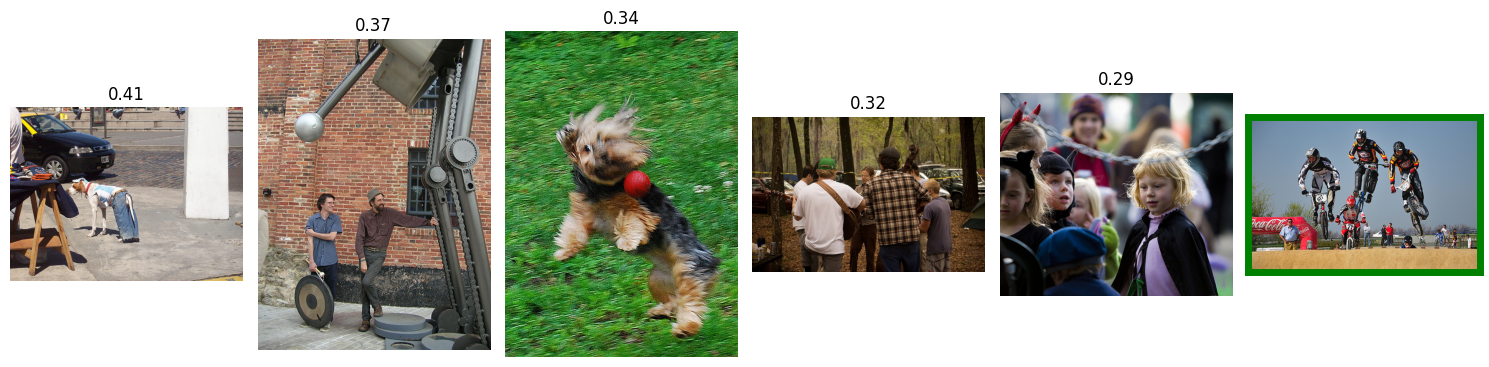

----------------------------------------------------------------------------------------------------

A cyclist riding on their front wheel on the asphalt .




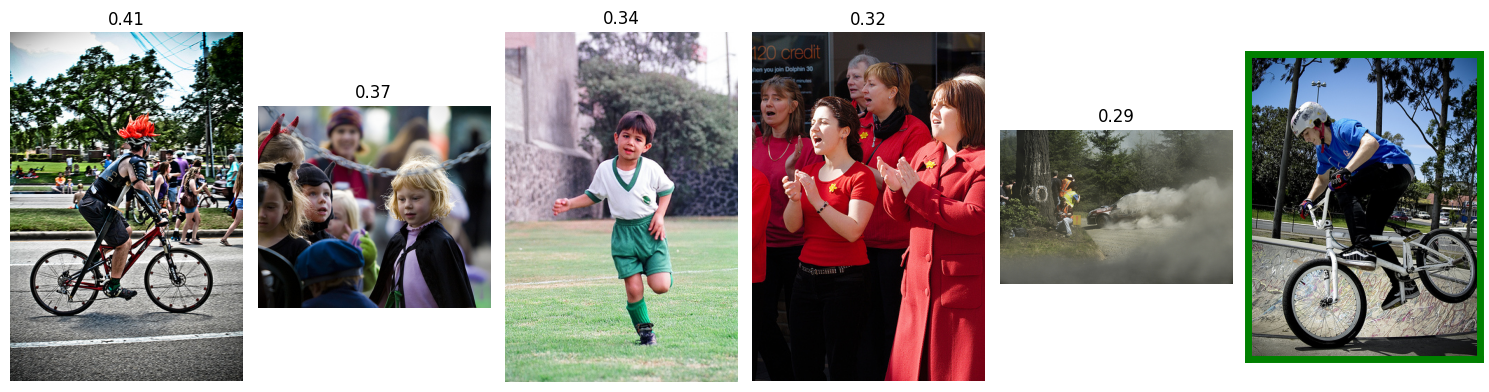

----------------------------------------------------------------------------------------------------

Three men form an arch during a BMX bike race sponsored by Coca-Cola .




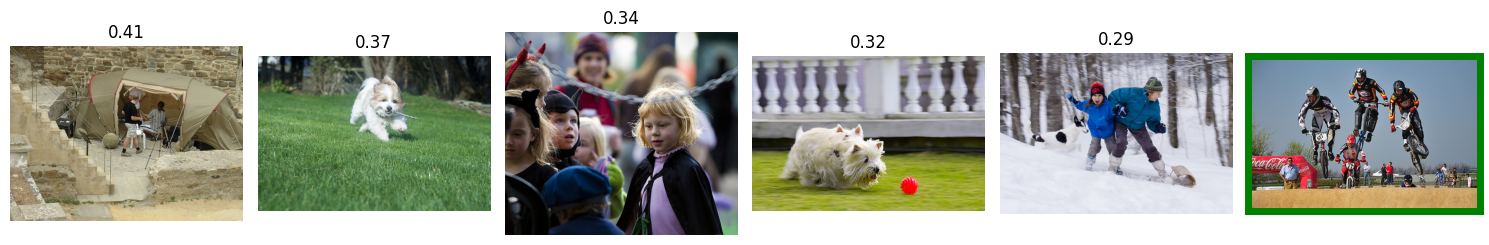

----------------------------------------------------------------------------------------------------

Two black dogs are tugging at an orange toy that is between them .




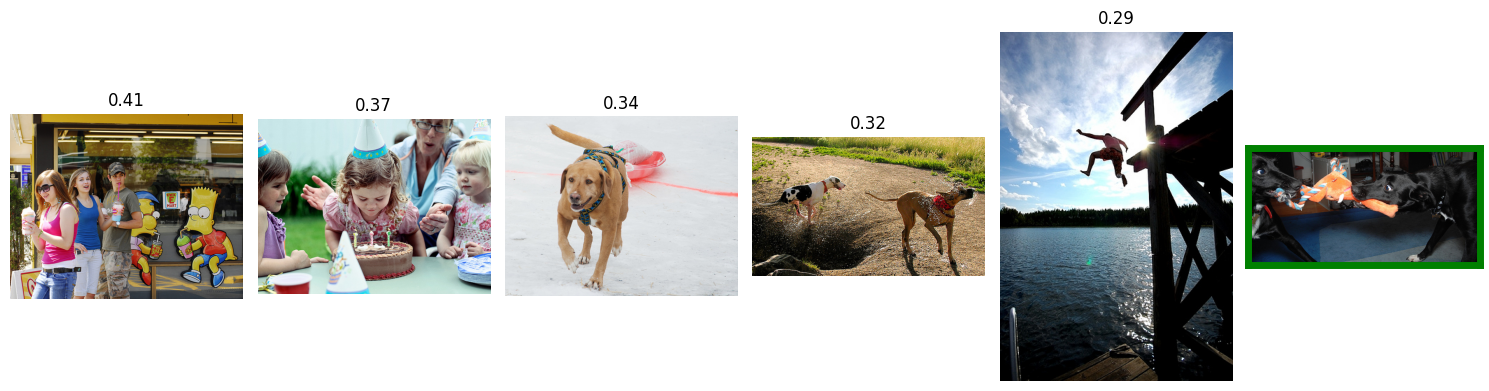

----------------------------------------------------------------------------------------------------

Five women in red shirts clapping .




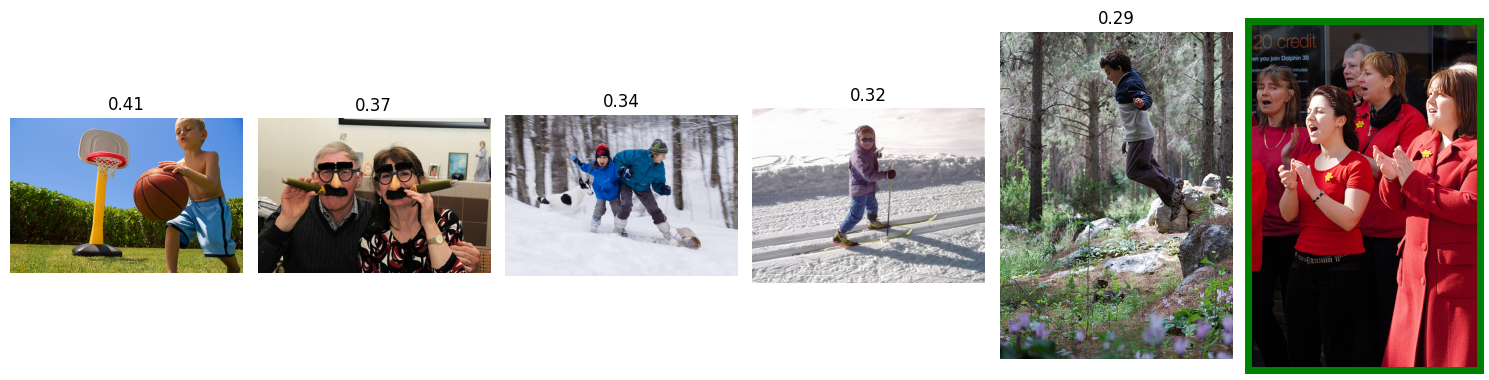

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Two young boys are squirting water at each other .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################



In [66]:
test_phrases = list(df_queries['query_text'].sample(10))
for text in test_phrases:
    get_picture(text)


## clip-ViT-B-32

In [67]:
# обучать будем на специальной модели OpenAI
model_clip = SentenceTransformer('clip-ViT-B-32')

In [68]:
test_paths = list(glob.glob(str(Path(PATH, 'test_images', '*.jpg'))))

In [69]:
# получаем эмбеддинги тестовых фото
image_embed = model_clip.encode([Image.open(i) for i in test_paths],
                                   convert_to_tensor=True,
                                   batch_size=16,
                                   show_progress_bar=True)

image_embed.shape


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([100, 512])

In [70]:
# функция для теста работы модели и визульного контроля качества
def search(query_text, k: int):
    acc = []
    bin_array = [i for i in lemmas(query_text) if i in WORD_TO_BLOCK]
    if bin_array:
        print('-'*100)
        print()
        print(query_text)
        print()
        print('#'*77)
        s = 'This image is unavailable in your country in compliance with local laws'.upper()
        print(f'## {s} ##')
        print('#'*77)
        print()
    else:
        text_embedings = model_clip.encode([query_text],
                                           convert_to_tensor=True,
                                           show_progress_bar=False)

        top = util.semantic_search(text_embedings, image_embed, top_k=k)[0]
        print(query_text)
        print()
        fig = plt.figure(figsize=(15,6))
        plt.rcParams['axes.edgecolor'] = 'white'
        plt.rcParams['axes.linewidth'] = 5
        for i in range(k):
            fig.add_subplot(1, 6, i+1, title=round(top[i]['score'], 2))
            image = Image.open(test_paths[top[i]['corpus_id']])
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if query in list(df_queries['query_text']):
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == query_text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            print()

        plt.show()

        print('-'*100)
    return None

A long-haired brown and white dog carries a snowball in his mouth .




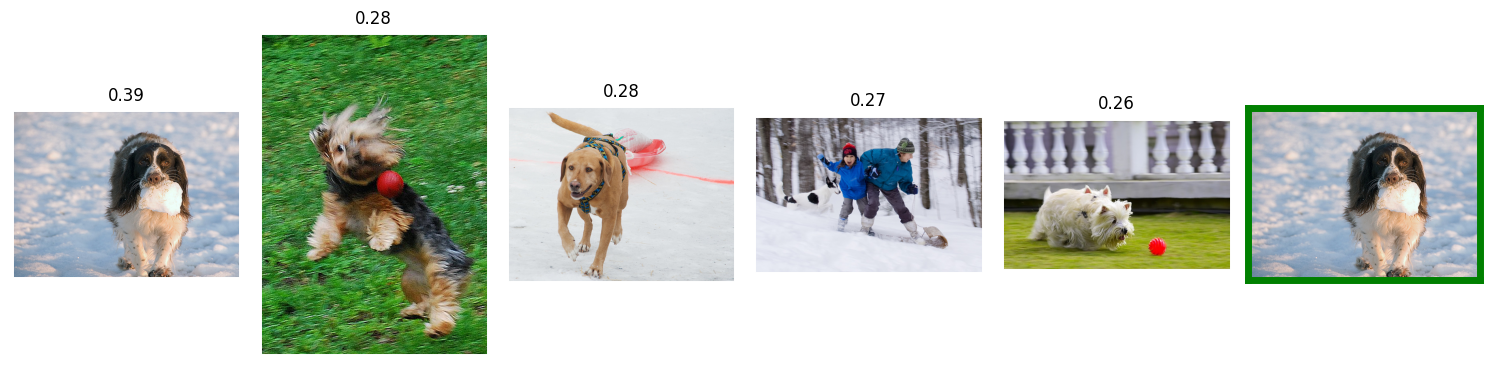

----------------------------------------------------------------------------------------------------
Two women are operating a laptop connected to a camera in a parking lot with a third person standing by .




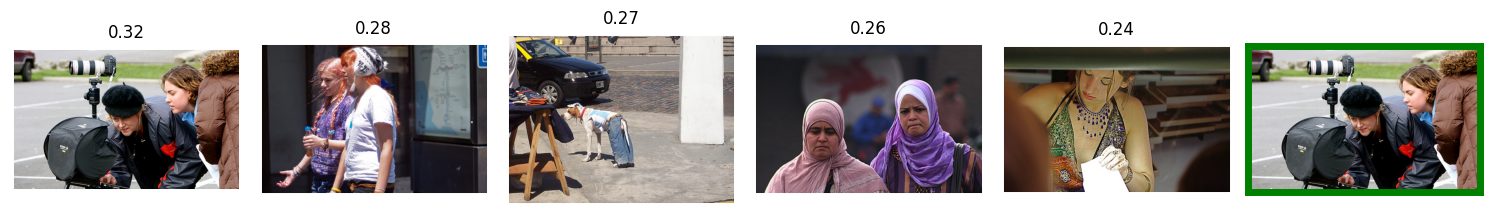

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Young boys enjoying a spray of water .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

A young boy jumps off a rock in the forest

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

A boy holds a red bucket up to a pony .

In [71]:
k = 5

for query in list(df_queries.sample(k)['query_text']):
    search(query_text = query, k = k)

## 8. Вывод


В ходе работе провели агрегацию оценок экспертов и оценок полученных с помощью краудсорсинга. С помощью сети ResNet50 векторизировали фото, для векторизации текстов использовали DistilBert. Обучили линейную модель и полносвязную нейронную сеть, в качестве метрики остановились на RMSE, cреднеквадратичная ошибка хорошо подходит для задач регрессии, где необходимо оценить отклонение предсказанных значений от истинных значений в тех же единицах измерения. Чем ближе значение к нулю, тем лучше качество.  
 - RMSE линейная регрессия = 21.63%
 - RMSE нейронной сети = 21.97%


Как показала себя тестовая часть по визуальному контролю, модель линейной регрессии в основном ошибается. Причиной является недостаток количества размеченных данных.



